In [ ]:
import extract_hkm_cmdty
import load_futures_data
import calc_futures_returns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from replicate_cmdty import generate_corr_matrix, decide_optimal_pairs

# Commodity Return Replication – Walkthrough
This notebook outlines the steps taken to generate an approximate replication of the commodity return series presented in He, Kelly, and Manela (2017).

## Overview

He, Kelly, and Manela constructed monthly returns for 23 commodities selected from a larger set of 31 commodities originally studied by Yang (2013). These commodities were chosen based on data availability from the Commodity Research Bureau (CRB), requiring at least 25 years of monthly returns data. He, Kelly, and Manela employed an equal-weighted portfolio of all futures contracts with maturities of four months or less, slightly modifying Yang’s original method, which used contracts with maturities between one month and twelve months.

*Note: the Yang paper ranges from 197101-200812 and hkm ranges from 198609-201212*

However, when attempting direct replication, we encountered significant data limitations. The CRB dataset, as originally utilized by Yang and subsequently He, Kelly, and Manela, is not readily accessible. Matching the precise contract numbers listed in Yang’s Table 1 ("N" values) was also impractical given current dataset constraints.

> While it may not be perfectly accurate—since neither the Yang nor the HKM papers specify the yearspan of the commodities they used—we can still make a reasonable inference. Both studies rely on the same underlying dataset. By sorting Yang’s table of commodities by the number of monthly observations (N), we can roughly estimate which commodities were likely selected by HKM, given their stated requirement of at least 25 years of monthly return data.


In [73]:
data = [
    ["Agriculture", "Barley", "WA", 235, -3.66, 27.66, -0.24, 19.62, -1.21],
    ["Agriculture", "Butter", "O2", 141, -3.68, 33.33, 3.66, 27.22, 13.46],
    ["Agriculture", "Canola", "WC", 377, -2.98, 33.16, -0.18, 19.82, -0.89],
    ["Agriculture", "Cocoa", "CC", 452, -2.61, 25.22, 4.52, 30.32, 14.90],
    ["Agriculture", "Coffee", "KC", 420, -2.57, 36.90, 6.00, 36.52, 16.44],
    ["Agriculture", "Corn", "C-", 468, -6.03, 23.08, -0.01, 23.35, -0.04],
    ["Agriculture", "Cotton", "CT", 452, -1.75, 36.50, 3.60, 22.96, 15.69],
    ["Agriculture", "Lumber", "LB", 468, -5.63, 33.55, -1.13, 22.80, -4.98],
    ["Agriculture", "Oats", "O-", 468, -5.65, 31.20, 0.44, 28.90, 1.53],
    ["Agriculture", "Orange juice", "JO", 448, -3.08, 36.61, 2.32, 29.56, 7.86],
    ["Agriculture", "Rough rice", "RR", 265, -7.56, 26.04, -1.50, 25.01, -6.01],
    ["Agriculture", "Soybean meal", "SM", 468, 0.20, 44.87, 7.80, 28.63, 27.25],
    ["Agriculture", "Soybeans", "S-", 468, -0.58, 37.18, 5.99, 26.25, 22.81],
    ["Agriculture", "Wheat", "W-", 468, -2.88, 38.68, 2.79, 23.76, 11.72],
    ["Energy", "Crude oil", "CL", 295, 4.25, 66.78, 10.56, 27.87, 37.89],
    ["Energy", "Gasoline", "RB", 275, 8.09, 70.91, 12.82, 30.18, 42.47],
    ["Energy", "Heating oil", "HO", 345, 1.49, 55.65, 9.50, 28.65, 33.15],
    ["Energy", "Natural gas", "NG", 216, -3.63, 43.06, 8.66, 34.63, 25.00],
    ["Energy", "Propane", "PN", 247, 5.53, 55.47, 14.28, 34.18, 41.77],
    ["Energy", "Unleaded gas", "HU", 250, 8.62, 71.20, 16.02, 29.24, 54.78],
    ["Livestock", "Broilers", "BR", 19, 4.58, 52.63, 1.49, 7.28, 20.53],
    ["Livestock", "Feeder cattle", "FC", 443, 0.35, 53.27, 4.43, 14.28, 31.01],
    ["Livestock", "Lean hogs", "LH", 468, 2.66, 59.40, 7.98, 22.34, 35.70],
    ["Livestock", "Live cattle", "LC", 468, 0.46, 50.64, 4.55, 14.92, 30.46],
    ["Metals", "Aluminum", "AL", 215, 1.06, 35.35, 5.46, 19.11, 28.56],
    ["Metals", "Coal", "QL", 85, -1.55, 34.12, 6.20, 30.02, 20.65],
    ["Metals", "Copper", "HG", 412, 0.52, 41.75, 4.62, 25.50, 18.12],
    ["Metals", "Gold", "GC", 400, -6.24, 0.00, 0.43, 19.88, 2.18],
    ["Metals", "Palladium", "PA", 362, -2.16, 30.66, 10.21, 35.19, 29.01],
    ["Metals", "Platinum", "PL", 410, -3.21, 23.66, 3.69, 27.81, 13.27],
    ["Metals", "Silver", "SI", 419, -6.51, 1.19, 0.44, 32.09, 1.37],
]

columns = [
    "Sector",
    "Commodity",
    "Symbol",
    "N",
    "Basis",
    "Freq. of bw.",
    "E[Rᵉ]",
    "σ[Rᵉ]",
    "Sharpe ratio",
]

df_yang = pd.DataFrame(data, columns=columns)

print(df_yang.sort_values("N", ascending=False).reset_index(drop=True))

    index       Sector      Commodity Symbol    N  Basis  Freq. of bw.  E[Rᵉ]  \
0      22    Livestock      Lean hogs     LH  468   2.66         59.40   7.98   
1      13  Agriculture          Wheat     W-  468  -2.88         38.68   2.79   
2      23    Livestock    Live cattle     LC  468   0.46         50.64   4.55   
3       5  Agriculture           Corn     C-  468  -6.03         23.08  -0.01   
4       7  Agriculture         Lumber     LB  468  -5.63         33.55  -1.13   
5       8  Agriculture           Oats     O-  468  -5.65         31.20   0.44   
6      11  Agriculture   Soybean meal     SM  468   0.20         44.87   7.80   
7      12  Agriculture       Soybeans     S-  468  -0.58         37.18   5.99   
8       3  Agriculture          Cocoa     CC  452  -2.61         25.22   4.52   
9       6  Agriculture         Cotton     CT  452  -1.75         36.50   3.60   
10      9  Agriculture   Orange juice     JO  448  -3.08         36.61   2.32   
11     21    Livestock  Feed

## Approach1 -- GSCI Indices
Fortunately, He, Kelly, and Manela mentioned an alternative method tested by Koijen, Moskowitz, Pedersen, and Vrugt (2018) (KMPV), which closely approximated their original findings. The KMPV paper explicitly provided Bloomberg tickers of 24 different commodities, enabling direct extraction of reliable and consistent monthly return data.

Thus, for our replication, we adopted the Bloomberg database following KMPV’s approach. Since KMPV did not explicitly present a calculation formula but rather directly extracted monthly returns from Bloomberg, our replication followed the same straightforward procedure.



In [74]:
df_return1 = load_futures_data.load_gsci_data()
df_return1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 728 entries, 196411 to 202506
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          728 non-null    datetime64[ns]
 1   SPGCBRP Index_PX_LAST_Return  317 non-null    float64       
 2   SPGCGOP Index_PX_LAST_Return  317 non-null    float64       
 3   SPGCCLP Index_PX_LAST_Return  461 non-null    float64       
 4   SPGCHUP Index_PX_LAST_Return  449 non-null    float64       
 5   SPGCHOP Index_PX_LAST_Return  509 non-null    float64       
 6   SPGCNGP Index_PX_LAST_Return  377 non-null    float64       
 7   SPGCCTP Index_PX_LAST_Return  581 non-null    float64       
 8   SPGCKCP Index_PX_LAST_Return  533 non-null    float64       
 9   SPGCCCP Index_PX_LAST_Return  497 non-null    float64       
 10  SPGCSBP Index_PX_LAST_Return  629 non-null    float64       
 11  SPGCSOP Index_PX_LAST_Return 

In [75]:
df_return1.tail(5)

Date  SPGCBRP Index_PX_LAST_Return  SPGCGOP Index_PX_LAST_Return  \
yyyymm                                                                          
202502 2025-02-28                     -0.032959                     -0.028765   
202503 2025-03-31                      0.034188                      0.016440   
202504 2025-04-30                     -0.176246                     -0.114556   
202505 2025-05-30                      0.034989                     -0.006110   
202506 2025-06-23                      0.216689                      0.260221   

        SPGCCLP Index_PX_LAST_Return  SPGCHUP Index_PX_LAST_Return  \
yyyymm                                                               
202502                     -0.035269                     -0.023258   
202503                      0.029411                      0.028073   
202504                     -0.179416                     -0.115157   
202505                      0.051259                      0.013584   
202506                      0.236079                      0.155847   

        SPGCHOP Index_PX_LAST_Return  SPGCNGP Index_PX_LAST_Return  \
yyyymm                                                               
202502                     -0.010092                      0.257536   
202503                     -0.001000                      0.060252   
202504                     -0.103167                     -0.215774   
202505                      0.015693                     -0.048471   
202506                      0.256024                      0.116291   

        SPGCCTP Index_PX_LAST_Return  SPGCKCP Index_PX_LAST_Return  \
yyyymm                                                               
202502                     -0.026085                      0.011168   
202503                      0.024215                      0.017960   
202504                     -0.023963                      0.061948   
202505                     -0.014541                     -0.145477   
202506                     -0.010310                     -0.074109   

        SPGCCCP Index_PX_LAST_Return  ...  SPGCLHP Index_PX_LAST_Return  \
yyyymm                                ...                                 
202502                     -0.181161  ...                     -0.073879   
202503                     -0.133932  ...                      0.009050   
202504                      0.133033  ...                      0.031488   
202505                      0.101722  ...                      0.034167   
202506                     -0.108304  ...                      0.053268   

        SPGCFCP Index_PX_LAST_Return  SPGCLCP Index_PX_LAST_Return  \
yyyymm                                                               
202502                     -0.009924                     -0.047701   
202503                      0.038689                      0.076125   
202504                      0.016751                      0.023324   
202505                      0.012880                      0.026952   
202506                      0.012130                      0.002269   

        SPGCGCP Index_PX_LAST_Return  SPGCSIP Index_PX_LAST_Return  \
yyyymm                                                               
202502                      0.004763                     -0.033119   
202503                      0.095406                      0.098902   
202504                      0.053582                     -0.060372   
202505                     -0.009677                      0.006123   
202506                      0.021203                      0.090602   

        SPGCIAP Index_PX_LAST_Return  SPGCIKP Index_PX_LAST_Return  \
yyyymm                                                               
202502                      0.003324                      0.011188   
202503                     -0.029835                      0.025278   
202504                     -0.056096                     -0.034990   
202505                      0.015721                     -0.016660   
202506                      0.046000        

In [77]:
hkm_df = extract_hkm_cmdty.extract_hkm_cmdty()

In [78]:
hkm_df.tail(5)

Commod_01  Commod_02  Commod_03  Commod_04  Commod_05  Commod_06  \
yyyymm                                                                     
201208    -0.0057     0.1002     0.0883     0.0801     0.0291     0.0444   
201209    -0.0558    -0.0366    -0.0479    -0.0950    -0.0196     0.0499   
201210    -0.0006    -0.0521    -0.0616    -0.0081     0.0113    -0.0313   
201211    -0.0079     0.0504     0.0203     0.0355    -0.0179    -0.0048   
201212    -0.0751    -0.1107     0.0197     0.0166     0.0403    -0.0216   

        Commod_07  Commod_08  Commod_09  Commod_10  ...  Commod_14  Commod_15  \
yyyymm                                              ...                         
201208     0.0095     0.1050     0.1311    -0.0655  ...     0.0297     0.0611   
201209     0.0847    -0.0085    -0.0490     0.0518  ...    -0.0702     0.0181   
201210    -0.0653    -0.0255    -0.0627    -0.1149  ...     0.0488    -0.0498   
201211     0.0329     0.0058     0.1388    -0.0705  ...    -0.0611     0.1182   
201212     0.0007    -0.0109    -0.0572    -0.0461  ...    -0.0860     0.0223   

        Commod_16  Commod_17  Commod_18  Commod_19  Commod_20  Commod_21  \
yyyymm                                                                     
201208     0.0817     0.1266    -0.0392     0.0656     0.1165     0.0673   
201209     0.0800     0.0228     0.0123    -0.0905     0.0951    -0.0907   
201210    -0.0558    -0.0519    -0.0422    -0.0342    -0.0675    -0.0138   
201211     0.0168     0.0480     0.0089    -0.0676     0.0272    -0.0855   
201212    -0.0417     0.0125    -0.0268    -0.0150    -0.0963    -0.0262   

        Commod_22  Commod_23  
yyyymm                        
201208    -0.0175     0.0100  
201209     0.0146    -0.0639  
201210    -0.0429     0.0288  
201211    -0.0205    -0.0328  
201212    -0.1042     0.0028  

[5 rows x 23 columns]

### Matching Procedure

Given that He, Kelly, and Manela presented anonymized commodities without explicit tickers or identifiers, we needed a systematic approach to match our Bloomberg-based commodities with the paper's 23 commodities. We computed the Pearson correlation matrix between our monthly return series and those presented in the paper. Then, we used the linear assignment algorithm to find the optimal one-to-one commodity matches, maximizing the total correlation between the two datasets.

In [79]:
corr_matrix1 = generate_corr_matrix(df_return1, hkm_df)

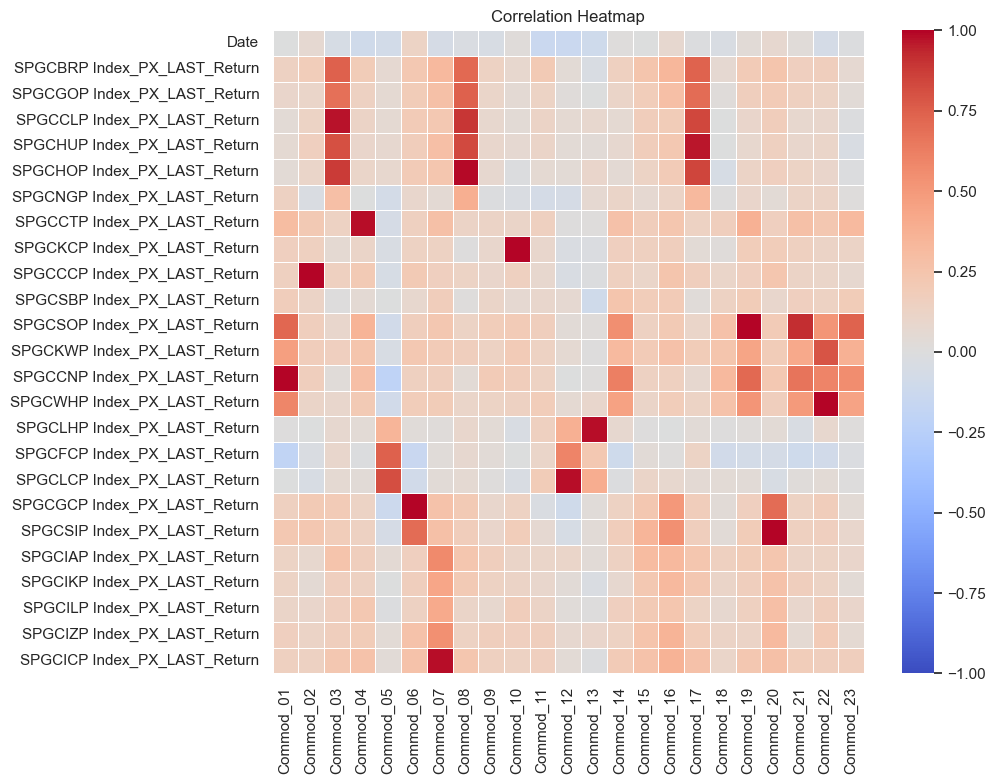

In [80]:
plt.figure(figsize=(10, 8))
corr_matrix_float1 = corr_matrix1.astype(float)
sns.heatmap(
    corr_matrix_float1,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [88]:
optimal_pairs_df1, col_ind, row_ind = decide_optimal_pairs(corr_matrix_float1)

In [82]:
ticker_to_commodity = {
    "SPGCBRP Index": "Crude Oil",
    "SPGCGOP Index": "Gasoil",
    "SPGCCLP Index": "WTI Crude",
    "SPGCHUP Index": "Unl. Gasoline",
    "SPGCHOP Index": "Heating Oil",
    "SPGCNGP Index": "Natural Gas",
    "SPGCCTP Index": "Cotton",
    "SPGCKCP Index": "Coffee",
    "SPGCCCP Index": "Cocoa",
    "SPGCSBP Index": "Sugar",
    "SPGCSOP Index": "Soybeans",
    "SPGCKWP Index": "Kansas Wheat",
    "SPGCCNP Index": "Corn",
    "SPGCWHP Index": "Wheat",
    "SPGCLHP Index": "Lean Hogs",
    "SPGCFCP Index": "Feeder Cattle",
    "SPGCLCP Index": "Live Cattle",
    "SPGCGCP Index": "Gold",
    "SPGCSIP Index": "Silver",
    "SPGCIAP Index": "Aluminum",
    "SPGCIKP Index": "Nickel",
    "SPGCILP Index": "Lead",
    "SPGCIZP Index": "Zinc",
    "SPGCICP Index": "Copper",
}

In [92]:
optimal_pairs_df1["GSCI Index"] = optimal_pairs_df1["Commodity_1"].str.replace(
    "_PX_LAST_Return", "", regex=False
)

# Map to real commodity names
optimal_pairs_df1["Commodity Name"] = optimal_pairs_df1["GSCI Index"].map(
    ticker_to_commodity
)
optimal_pairs_df1 = optimal_pairs_df1.rename(columns={"Commodity_2": "HKM Column Name"})

In [93]:
target_col = ["GSCI Index", "Commodity Name", "HKM Column Name", "Correlation"]
optimal_pairs_df1[target_col]

GSCI Index Commodity Name HKM Column Name  Correlation
0   SPGCGCP Index           Gold       Commod_06     0.997829
1   SPGCSIP Index         Silver       Commod_20     0.996492
2   SPGCCCP Index          Cocoa       Commod_02     0.995033
3   SPGCKCP Index         Coffee       Commod_10     0.994202
4   SPGCWHP Index          Wheat       Commod_22     0.993406
5   SPGCSOP Index       Soybeans       Commod_19     0.993210
6   SPGCCNP Index           Corn       Commod_01     0.992284
7   SPGCHOP Index    Heating Oil       Commod_08     0.989293
8   SPGCICP Index         Copper       Commod_07     0.983833
9   SPGCCTP Index         Cotton       Commod_04     0.980607
10  SPGCLHP Index      Lean Hogs       Commod_13     0.979089
11  SPGCLCP Index    Live Cattle       Commod_12     0.978834
12  SPGCCLP Index      WTI Crude       Commod_03     0.970168
13  SPGCHUP Index  Unl. Gasoline       Commod_17     0.967155
14  SPGCFCP Index  Feeder Cattle       Commod_05     0.748138
15  SPGCKWP Index   Kansas Wheat       Commod_21     0.418390
16  SPGCIZP Index           Zinc       Commod_16     0.352982
17  SPGCIAP Index       Aluminum       Commod_15     0.308407
18  SPGCBRP Index      Crude Oil       Commod_11     0.209755
19  SPGCSBP Index          Sugar       Commod_23     0.194204
20  SPGCILP Index           Lead       Commod_14     0.159347
21  SPGCIKP Index         Nickel       Commod_18     0.112268
22  SPGCGOP Index         Gasoil       Commod_09     0.105417

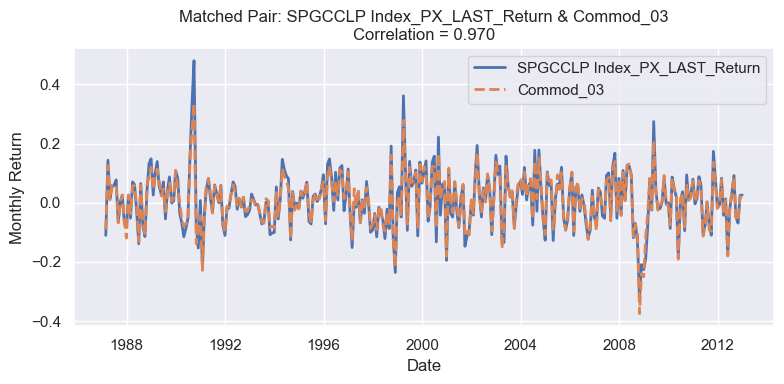

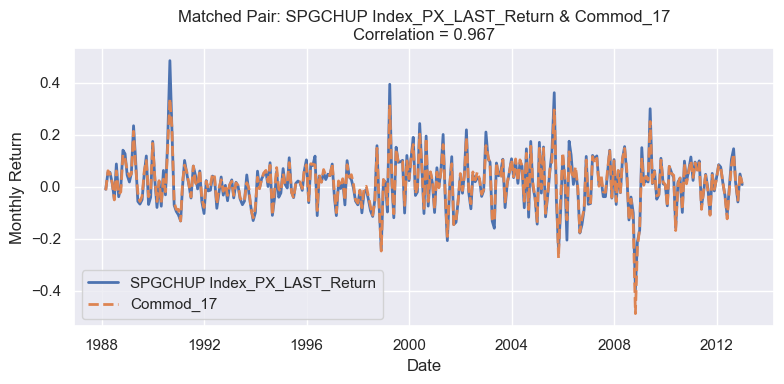

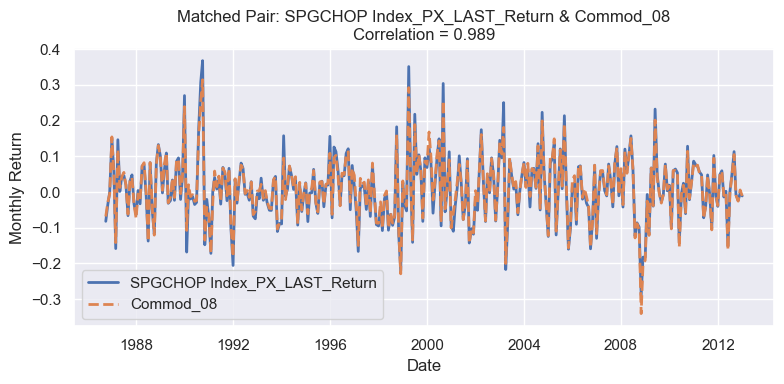

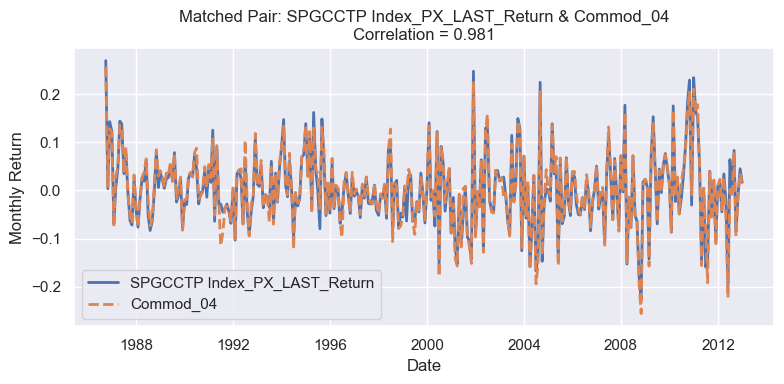

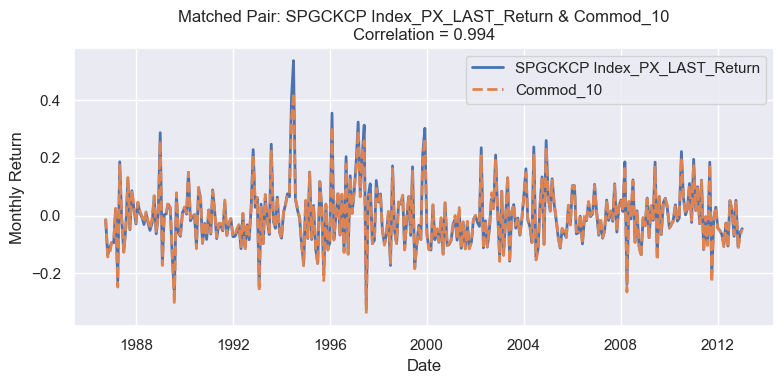

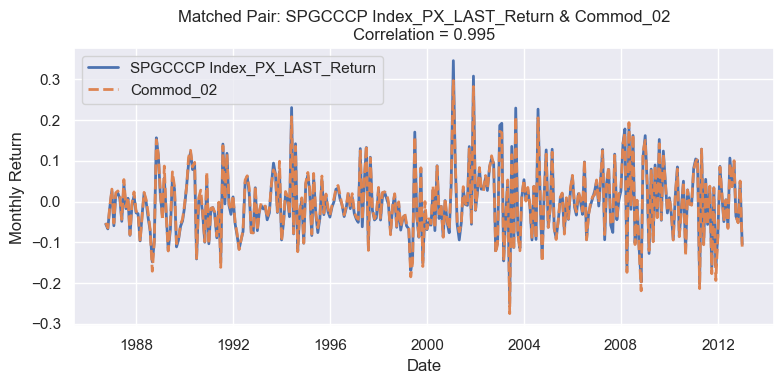

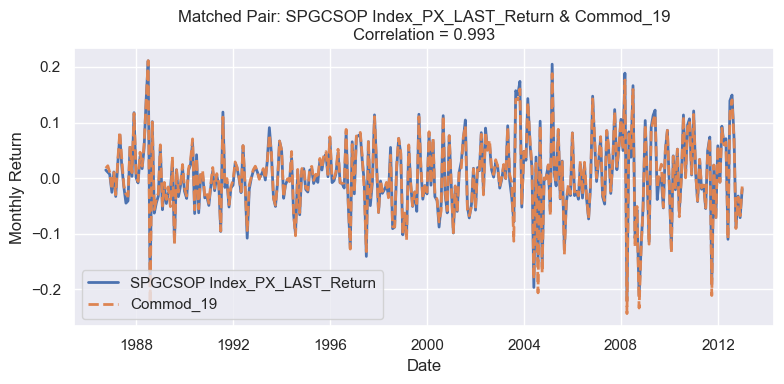

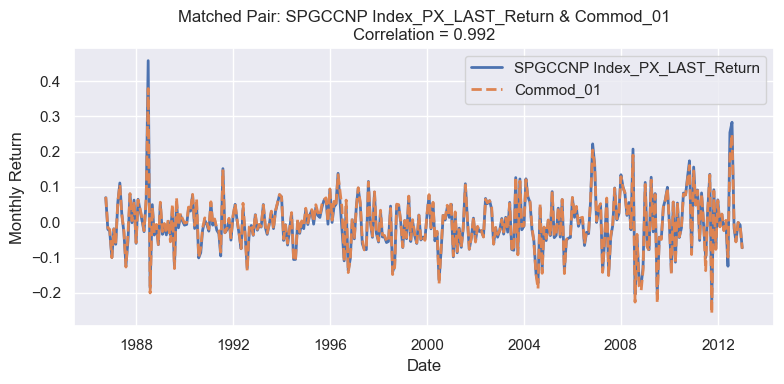

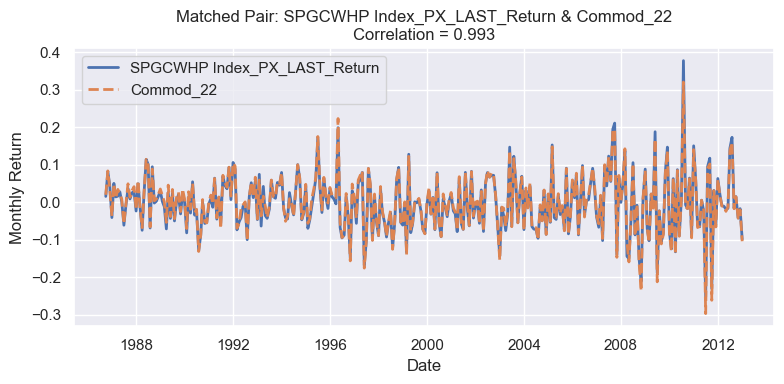

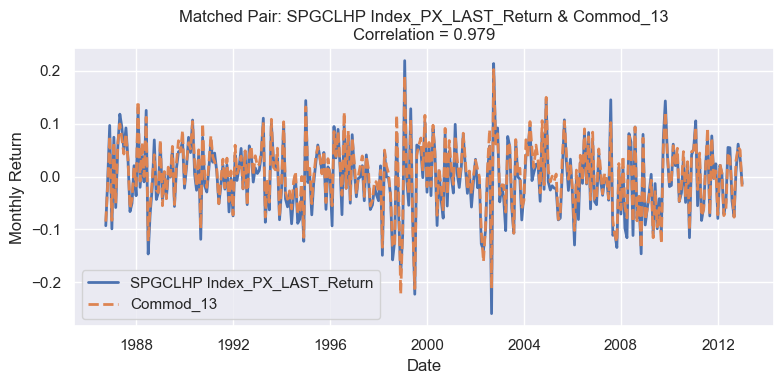

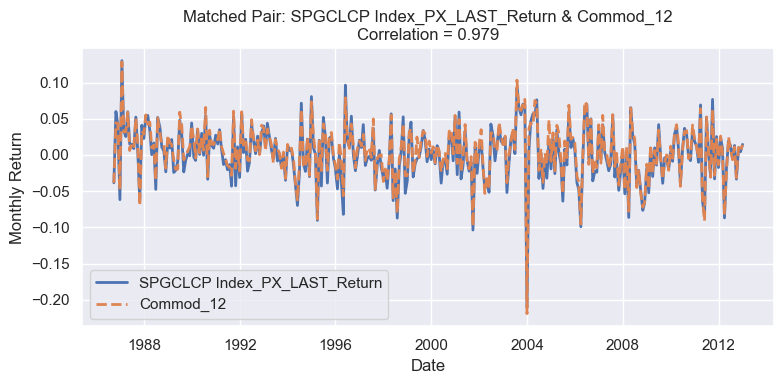

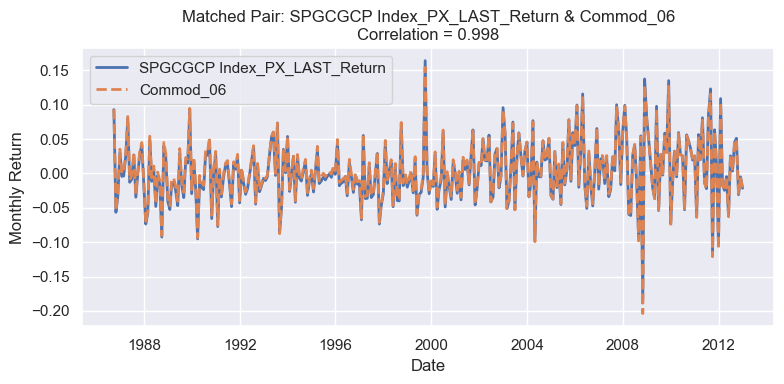

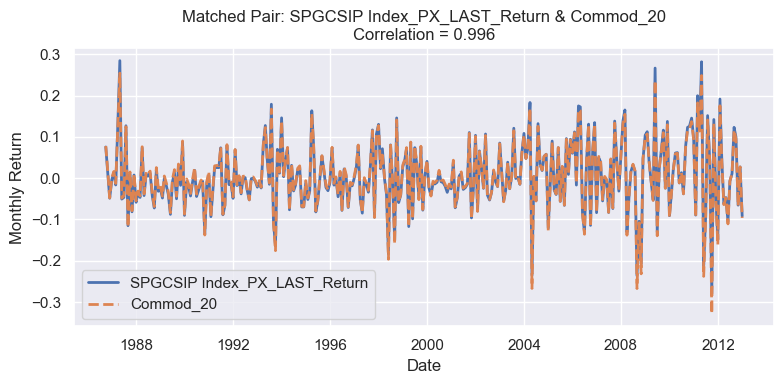

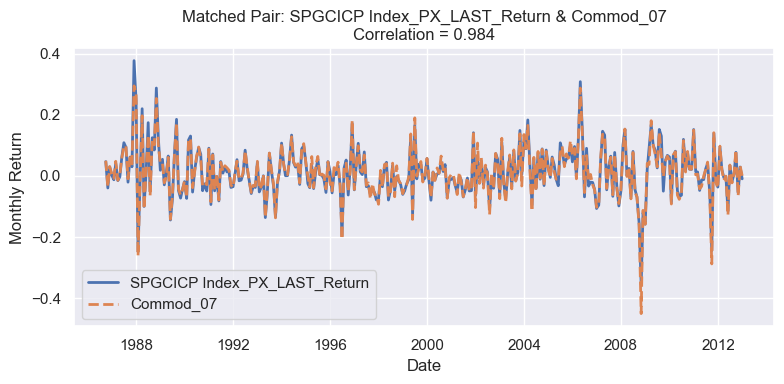

In [ ]:
df1 = df_return1.copy()
df2 = hkm_df.copy()

for r, c in zip(row_ind, col_ind):
    corr_value = corr_matrix1.iloc[r, c]
    if corr_value < 0.85:
        continue  # Skip low correlation pairs

    commodity_1 = corr_matrix1.index[r]
    commodity_2 = corr_matrix1.columns[c]

    merged = (
        pd.DataFrame(
            {
                "Date": df1["Date"],
                f"d1_{commodity_1}": df1[commodity_1],
                f"d2_{commodity_2}": df2[commodity_2],
            }
        )
        .dropna()
        .set_index("Date")
    )

    plt.figure(figsize=(8, 4))
    plt.plot(
        merged.index, merged[f"d1_{commodity_1}"], label=f"{commodity_1}", linewidth=2
    )
    plt.plot(
        merged.index,
        merged[f"d2_{commodity_2}"],
        label=f"{commodity_2}",
        linewidth=2,
        linestyle="--",
    )

    plt.title(
        f"Matched Pair: {commodity_1} & {commodity_2}\nCorrelation = {corr_value:.3f}"
    )
    plt.xlabel("Date")
    plt.ylabel("Monthly Return")
    plt.legend()
    plt.grid(True)

    plt.xticks()
    plt.tight_layout()
    plt.show()

## Generate Standardized table 

In [95]:
list_of_return_ticker = optimal_pairs_df1["Commodity_1"].to_list()

In [96]:
def wide_to_long_returns(df, list_of_return_ticker):
    """
    Converts a wide-format return DataFrame to long-format with columns: ds, unique_id, y
    """

    if "yyyymm" in df.columns:
        id_col = "yyyymm"
    elif "Date" in df.columns:
        id_col = "Date"
    else:
        raise ValueError("No date column found!")

    cols = [id_col] + list_of_return_ticker
    df_sub = df[cols].copy()

    df_long = df_sub.melt(
        id_vars=id_col,
        value_vars=list_of_return_ticker,
        var_name="unique_id",
        value_name="y",
    )
    df_long = df_long.rename(columns={id_col: "ds"})

    df_long = df_long.dropna(subset=["y"])

    df_long = df_long.sort_values(["unique_id", "ds"]).reset_index(drop=True)

    return df_long[["unique_id", "ds", "y"]]

In [97]:
gsci_replication_df = wide_to_long_returns(df_return1, list_of_return_ticker)

In [98]:
gsci_replication_df.head(5)

unique_id         ds         y
0  SPGCBRP Index_PX_LAST_Return 1999-02-26 -0.060203
1  SPGCBRP Index_PX_LAST_Return 1999-03-31  0.359040
2  SPGCBRP Index_PX_LAST_Return 1999-04-30  0.075051
3  SPGCBRP Index_PX_LAST_Return 1999-05-28 -0.057141
4  SPGCBRP Index_PX_LAST_Return 1999-06-30  0.132458

One source of deviation in our replication arises from differences in the underlying universe of commodities. The original HKM dataset selects 23 commodities from a broader pool of 31, whereas our replication process matches 23 out of 24 available contracts. Moreover, the two original pools themselves are not entirely overlapping, making mismatches almost inevitable. Commodities with correlations above 0.90 are likely those that overlap directly between the two datasets, while those with lower correlations often do not appear in the HKM table. Nevertheless, the strong alignment for major contracts supports the validity of using the GSCI index as an effective proxy for replicating the HKM methodology.

This interpretation is further supported by Yang’s table: although our replication remains an approximation—since HKM does not explicitly use GSCI data—we observe that the highly correlated tickers typically have at least 275 monthly observations in Yang’s datasets. This pattern suggests that these commodities were very likely included in the original HKM selection due to their long return histories.

## Alternative Approach 1
To closely follow the methodology of He, Kelly, and Manela (2017), we construct commodity return series based on constant one-month maturity futures prices. In their original approach, HKM derive such prices by linearly interpolating between the nearest, second-nearest, and third-nearest futures contracts. To approximate this, we use London Metal Exchange (LME) data where both cash and three-month futures prices are available, and compute a synthetic one-month price using a linear interpolation: $P_{1m} = P_{\text{cash}} + \frac{1}{3}(P_{3m} - P_{\text{cash}})$. This allows us to construct a monthly price series that mirrors the one-month maturity logic applied in HKM. For other commodities, we adopt the second-nearest (month-2) Bloomberg generic contracts (e.g., CO2 Comdty, NG2 Comdty) as a practical proxy for the interpolated price. Although this is a simplification, it maintains consistency with the spirit of HKM's approach and ensures comparability across commodities where interpolation is not feasible.


In [107]:
commodity_futures_df = load_futures_data.load_commodities_future()
lme_df = load_futures_data.load_lme_metals()

In [127]:
metal_map = {
    "Aluminum": ("LMAHDY Comdty_PX_LAST", "LMAHDS03 Comdty_PX_LAST"),
    "Nickel": ("LMNIDY Comdty_PX_LAST", "LMNIDS03 Comdty_PX_LAST"),
    "Lead": ("LMPBDY Comdty_PX_LAST", "LMPBDS03 Comdty_PX_LAST"),
    "Zinc": ("LMZSDY Comdty_PX_LAST", "LMZSDS03 Comdty_PX_LAST"),
    "Copper": ("LMCADY Comdty_PX_LAST", "LMCADS03 Comdty_PX_LAST"),
}

monthly_1mprice = calc_futures_returns.calc_lme_monthly_1mprice(
    lme_df, metal_map, date_col="index"
)

lme_monthly_return = calc_futures_returns.calc_lme_monthly_return(monthly_1mprice)

print(lme_monthly_return.head())

   yyyymm       Date  Aluminum    Nickel      Lead  Zinc    Copper
0  198709 1987-09-30  0.101317 -0.019891 -0.137613   NaN  0.073357
1  198710 1987-10-31 -0.058047  0.026383  0.016215   NaN  0.080608
2  198711 1987-11-30 -0.071148  0.073554  0.127458   NaN  0.378630
3  198712 1987-12-31  0.204262  0.350032  0.002539   NaN  0.113221
4  198801 1988-01-31 -0.036728 -0.042974  0.005976   NaN -0.249536


In [129]:
cmt_monthly_return = calc_futures_returns.compute_second_contract_return(
    commodity_futures_df
)
cmt_monthly_return.head()

C:\Users\Yangge Xu\AppData\Local\Temp\ipykernel_23036\944567621.py:14: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret_df = df_monthly[second_contract_cols].pct_change()


yyyymm       Date  CO2 Comdty_PX_LAST  QS2 Comdty_PX_LAST  \
0  195907 1959-07-31                 NaN                 NaN   
1  195908 1959-08-31                 NaN                 NaN   
2  195909 1959-09-30                 NaN                 NaN   
3  195910 1959-10-31                 NaN                 NaN   
4  195911 1959-11-30                 NaN                 NaN   

   CL2 Comdty_PX_LAST  XB2 Comdty_PX_LAST  HO2 Comdty_PX_LAST  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   NG2 Comdty_PX_LAST  CT2 Comdty_PX_LAST  KC2 Comdty_PX_LAST  ...  \
0                 NaN                 NaN                 NaN  ...   
1                 NaN            0.011952                 NaN  ...   
2                 NaN           -0.003609                 NaN  ...   
3                 NaN            0.005927                 NaN  ...   
4                 NaN            0.011457                 NaN  ...   

   SB2 Comdty_PX_LAST  S 2 Comdty_PX_LAST  KW2 Comdty_PX_LAST  \
0                 NaN                 NaN                 NaN   
1                 NaN           -0.044835                 NaN   
2                 NaN            0.031491                 NaN   
3                 NaN            0.021889                 NaN   
4                 NaN            0.001127                 NaN   

   C 2 Comdty_PX_LAST  W 2 Comdty_PX_LAST  LH2 Comdty_PX_LAST  \
0                 NaN                 NaN                 NaN   
1           -0.015385            0.005096                 NaN   
2            0.014509            0.018378                 NaN   
3            0.005501            0.016179                 NaN   
4            0.000000           -0.004287                 NaN   

   FC2 Comdty_PX_LAST  LC2 Comdty_PX_LAST  GC2 Comdty_PX_LAST  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   SI2 Comdty_PX_LAST  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  

[5 rows x 21 columns]

In [138]:
combined_df = pd.merge(
    cmt_monthly_return,
    lme_monthly_return.drop(columns=["Date"]),
    how="inner",
    on=["yyyymm"],
    suffixes=("", "_LME"),
).set_index("yyyymm")

In [139]:
combined_df

Date  CO2 Comdty_PX_LAST  QS2 Comdty_PX_LAST  CL2 Comdty_PX_LAST  \
yyyymm                                                                          
198709 1987-09-30                 NaN                 NaN           -0.001026   
198710 1987-10-31                 NaN                 NaN            0.018480   
198711 1987-11-30                 NaN                 NaN           -0.075605   
198712 1987-12-31                 NaN                 NaN           -0.095420   
198801 1988-01-31                 NaN                 NaN            0.015069   
...           ...                 ...                 ...                 ...   
202502 2025-02-28           -0.037796           -0.041726           -0.036677   
202503 2025-03-31            0.026919            0.006642            0.023219   
202504 2025-04-30           -0.183362           -0.122434           -0.187879   
202505 2025-05-31            0.028169           -0.012949            0.037661   
202506 2025-06-30            0.063077            0.118917            0.067904   

        XB2 Comdty_PX_LAST  HO2 Comdty_PX_LAST  NG2 Comdty_PX_LAST  \
yyyymm                                                               
198709                 NaN            0.040871                 NaN   
198710                 NaN            0.049358                 NaN   
198711                 NaN           -0.040567                 NaN   
198712                 NaN           -0.130126                 NaN   
198801                 NaN           -0.011314                 NaN   
...                    ...                 ...                 ...   
202502            0.079415           -0.034330            0.269055   
202503            0.030779           -0.015378            0.092659   
202504           -0.119178           -0.121786           -0.146112   
202505           -0.001289            0.001798           -0.030812   
202506            0.028286            0.135085           -0.009367   

        CT2 Comdty_PX_LAST  KC2 Comdty_PX_LAST  CC2 Comdty_PX_LAST  ...  \
yyyymm                                                              ...   
198709           -0.062451           -0.019714           -0.071968  ...   
198710           -0.053678            0.090409            0.003254  ...   
198711            0.023071            0.022226            0.008649  ...   
198712           -0.028296           -0.010177           -0.012862  ...   
198801           -0.077458            0.046035           -0.028230  ...   
...                    ...                 ...                 ...  ...   
202502           -0.026700            0.004578           -0.159466  ...   
202503            0.041992            0.006299           -0.135467  ...   
202504           -0.028975            0.067528            0.126648  ...   
202505            0.021509           -0.152090            0.037470  ...   
202506            0.003559           -0.116833           -0.023861  ...   

        LH2 Comdty_PX_LAST  FC2 Comdty_PX_LAST  LC2 Comdty_PX_LAST  \
yyyymm                                                               
198709           -0.070697            0.000000           -0.006711   
198710           -0.081588           -0.079132           -0.092342   
198711            0.023409            0.023909            0.021092   
198712           -0.097947            0.027073            0.059862   
198801            0.149545            0.017068            0.036380   
...                    ...                 ...                 ...   
202502           -0.032374           -0.007724           -0.047701   
202503            0.011152            0.042125            0.057098   
202504            0.111708            0.036995            0.023324   
202505            0.067667            0.009067            0.004559   
202506            0.024541            0.043416            0.021615   

        GC2 Comdty_PX_LAST  SI2 Comdty_PX_LAST  Aluminum    Nickel      Lead  \
yyyymm                                                                         
1

In [140]:
common_idx = hkm_df.index.intersection(combined_df.index)

In [141]:
he_kelly_sub = hkm_df.loc[common_idx]
carry_sub = combined_df.loc[common_idx]

In [145]:
corr_matrix2 = generate_corr_matrix(he_kelly_sub, carry_sub)

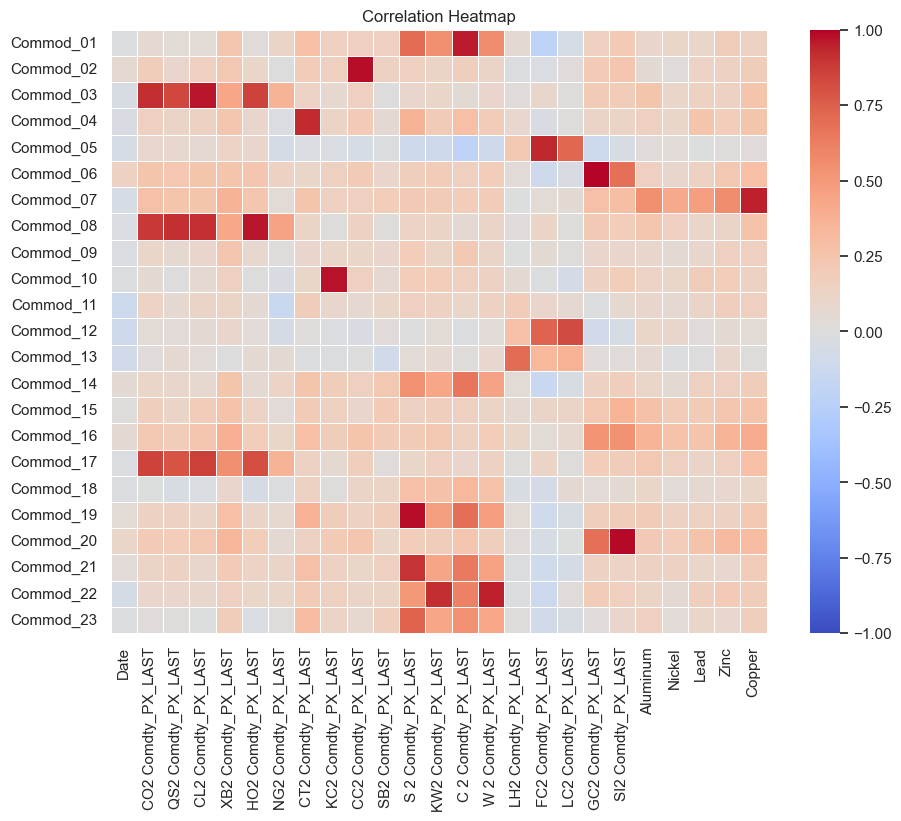

In [146]:
plt.figure(figsize=(10, 8))
corr_matrix_float2 = corr_matrix2.astype(float)
sns.heatmap(
    corr_matrix_float2,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [147]:
optimal_pairs_df2, col_ind, row_ind = decide_optimal_pairs(corr_matrix_float2)

In [148]:
optimal_pairs_df2

Commodity_1         Commodity_2  Correlation
0    Commod_06  GC2 Comdty_PX_LAST     0.996136
1    Commod_20  SI2 Comdty_PX_LAST     0.990287
2    Commod_02  CC2 Comdty_PX_LAST     0.983713
3    Commod_19  S 2 Comdty_PX_LAST     0.976728
4    Commod_10  KC2 Comdty_PX_LAST     0.971527
5    Commod_03  CL2 Comdty_PX_LAST     0.961483
6    Commod_08  HO2 Comdty_PX_LAST     0.960983
7    Commod_01  C 2 Comdty_PX_LAST     0.953613
8    Commod_07              Copper     0.952118
9    Commod_22  W 2 Comdty_PX_LAST     0.949708
10   Commod_05  FC2 Comdty_PX_LAST     0.930403
11   Commod_04  CT2 Comdty_PX_LAST     0.925083
12   Commod_17  CO2 Comdty_PX_LAST     0.854062
13   Commod_12  LC2 Comdty_PX_LAST     0.825750
14   Commod_13  LH2 Comdty_PX_LAST     0.703030
15   Commod_23  KW2 Comdty_PX_LAST     0.429840
16   Commod_16            Aluminum     0.353190
17   Commod_09  XB2 Comdty_PX_LAST     0.235590
18   Commod_14  SB2 Comdty_PX_LAST     0.223800
19   Commod_15              Nickel     0.192999
20   Commod_11                Zinc     0.168622
21   Commod_21  QS2 Comdty_PX_LAST     0.145876
22   Commod_18                Lead     0.064478

In [152]:
ticker_to_commodity = {
    "CO2 Comdty_PX_LAST": "Crude Oil",
    "QS2 Comdty_PX_LAST": "Gasoil",
    "CL2 Comdty_PX_LAST": "WTI Crude",
    "XB2 Comdty_PX_LAST": "Unl. Gasoline",
    "HO2 Comdty_PX_LAST": "Heating Oil",
    "NG2 Comdty_PX_LAST": "Natural Gas",
    "CT2 Comdty_PX_LAST": "Cotton",
    "KC2 Comdty_PX_LAST": "Coffee",
    "CC2 Comdty_PX_LAST": "Cocoa",
    "SB2 Comdty_PX_LAST": "Sugar",
    "S 2 Comdty_PX_LAST": "Soybeans",
    "KW2 Comdty_PX_LAST": "Kansas Wheat",
    "C 2 Comdty_PX_LAST": "Corn",
    "W 2 Comdty_PX_LAST": "Wheat",
    "LH2 Comdty_PX_LAST": "Lean Hogs",
    "FC2 Comdty_PX_LAST": "Feeder Cattle",
    "LC2 Comdty_PX_LAST": "Live Cattle",
    "GC2 Comdty_PX_LAST": "Gold",
    "SI2 Comdty_PX_LAST": "Silver",
    "Aluminum": "Aluminum",
    "Nickel": "Nickel",
    "Lead": "Lead",
    "Zinc": "Zinc",
    "Copper": "Copper",
}


optimal_pairs_df2["Commodity_Name"] = optimal_pairs_df2["Commodity_2"].map(
    ticker_to_commodity
)

In [154]:
optimal_pairs_df2[["Commodity_Name", "Commodity_1", "Correlation"]]

Commodity_Name Commodity_1  Correlation
0            Gold   Commod_06     0.996136
1          Silver   Commod_20     0.990287
2           Cocoa   Commod_02     0.983713
3        Soybeans   Commod_19     0.976728
4          Coffee   Commod_10     0.971527
5       WTI Crude   Commod_03     0.961483
6     Heating Oil   Commod_08     0.960983
7            Corn   Commod_01     0.953613
8          Copper   Commod_07     0.952118
9           Wheat   Commod_22     0.949708
10  Feeder Cattle   Commod_05     0.930403
11         Cotton   Commod_04     0.925083
12      Crude Oil   Commod_17     0.854062
13    Live Cattle   Commod_12     0.825750
14      Lean Hogs   Commod_13     0.703030
15   Kansas Wheat   Commod_23     0.429840
16       Aluminum   Commod_16     0.353190
17  Unl. Gasoline   Commod_09     0.235590
18          Sugar   Commod_14     0.223800
19         Nickel   Commod_15     0.192999
20           Zinc   Commod_11     0.168622
21         Gasoil   Commod_21     0.145876
22           Lead   Commod_18     0.064478

In [155]:
list_of_return_ticker = optimal_pairs_df2["Commodity_2"].to_list()

In [156]:
gsci_replication_df = wide_to_long_returns(combined_df, list_of_return_ticker)

In [157]:
gsci_replication_df.head(5)

unique_id         ds         y
0  Aluminum 1987-09-30  0.101317
1  Aluminum 1987-10-31 -0.058047
2  Aluminum 1987-11-30 -0.071148
3  Aluminum 1987-12-31  0.204262
4  Aluminum 1988-01-31 -0.036728

## Alternative Approach 2
Another method we explored—which yielded better results—involved using Bloomberg tickers listed by KMPV. While this approach does not strictly follow the procedures outlined by the original authors, it represents a hybrid of the methodologies used by Yang and KMPV. Specifically, we included more tickers than KMPV originally listed, expanding the universe while maintaining consistency in the return calculation process. Since He, Kelly, and Manela ultimately computed the returns themselves, our initial motivation for this approach was to better mimic their methodology. Despite being an approximation, this method has produced the most accurate replication results thus far.

In [ ]:
df = load_futures_data.load_commodities_manual()

In [196]:
monthly_return = calc_futures_returns.calc_return_manual(df)

NameError: name 'calc_futures_returns' is not defined

In [169]:
monthly_return["yyyymm"] = monthly_return["Month"].dt.strftime("%Y%m")

In [170]:
monthly_return = monthly_return.set_index("yyyymm")

In [174]:
corr_matrix3 = generate_corr_matrix(monthly_return, hkm_df)

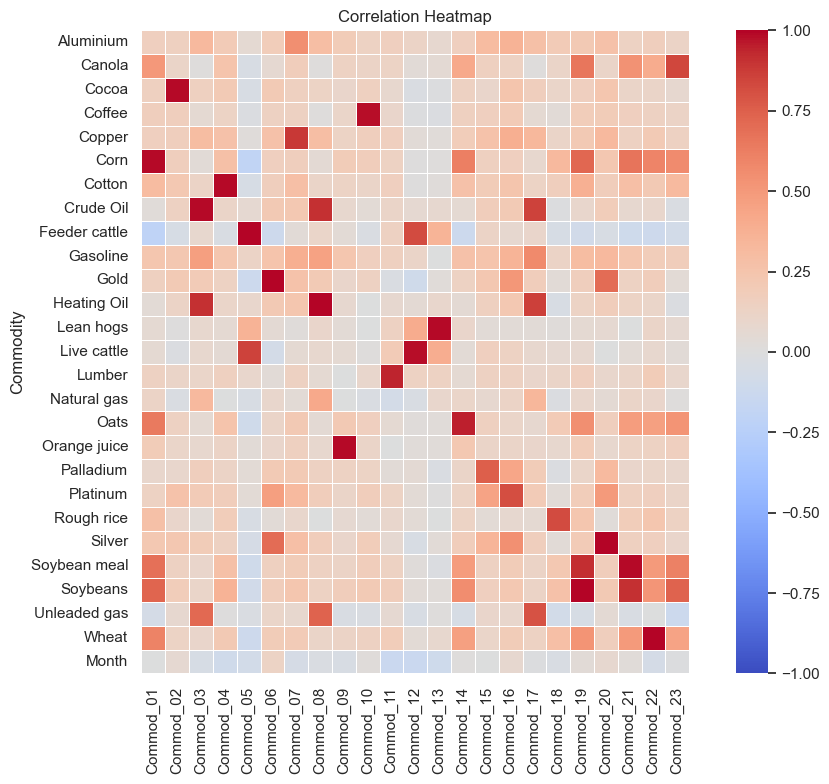

In [175]:
plt.figure(figsize=(10, 8))
corr_matrix_float3 = corr_matrix3.astype(float)
sns.heatmap(
    corr_matrix_float3,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar=True,
)

plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [184]:
corr_matrix_float3

Commod_01  Commod_02  Commod_03  Commod_04  Commod_05  \
Commodity                                                              
Aluminium       0.159858   0.155719   0.321346   0.199987   0.061497   
Canola          0.500323   0.111471   0.014086   0.253448  -0.044369   
Cocoa           0.153453   0.991497   0.151533   0.203806  -0.041105   
Coffee          0.166820   0.165539   0.059063   0.132592  -0.018679   
Copper          0.157427   0.170291   0.302503   0.272364   0.020131   
Corn            0.991776   0.166403   0.034626   0.277042  -0.192588   
Cotton          0.309256   0.219625   0.123122   0.986280  -0.051900   
Crude Oil       0.028279   0.147826   0.987131   0.111348   0.064805   
Feeder cattle  -0.205766  -0.049297   0.079078  -0.033503   0.995064   
Gasoline        0.240904   0.227013   0.472016   0.237601   0.124536   
Gold            0.153469   0.206364   0.195965   0.133475  -0.122290   
Heating Oil     0.044690   0.124125   0.909465   0.102193   0.087945   
Lean hogs       0.056697   0.005118   0.078125   0.060413   0.363710   
Live cattle     0.055027  -0.015641   0.084617   0.047823   0.858235   
Lumber          0.141312   0.114773   0.108281   0.149930   0.090434   
Natural gas     0.122112  -0.023741   0.321622  -0.007422  -0.045493   
Oats            0.641801   0.140938   0.056795   0.253606  -0.094580   
Orange juice    0.187888   0.105771   0.083589   0.119483   0.035325   
Palladium       0.090462   0.088049   0.168730   0.121162   0.040003   
Platinum        0.139348   0.265151   0.195797   0.179288   0.039563   
Rough rice      0.275785   0.094767   0.037282   0.182012  -0.040859   
Silver          0.223925   0.232461   0.188564   0.142110  -0.055091   
Soybean meal    0.686536   0.145880   0.095821   0.278264  -0.096006   
Soybeans        0.733523   0.179970   0.104817   0.366501  -0.092581   
Unleaded gas   -0.064528   0.078104   0.715759   0.005020  -0.023734   
Wheat           0.609035   0.125710   0.100522   0.217728  -0.114037   
Month          -0.000076   0.063549  -0.053171  -0.095893  -0.082455   

               Commod_06  Commod_07  Commod_08  Commod_09  Commod_10  ...  \
Commodity                                                             ...   
Aluminium       0.187311   0.553866   0.292089   0.193387   0.136166  ...   
Canola          0.065802   0.177745   0.014723   0.135259   0.123495  ...   
Cocoa           0.204180   0.152870   0.125861   0.099998   0.148714  ...   
Coffee          0.145369   0.145693   0.010726   0.102405   0.984072  ...   
Copper          0.265961   0.884589   0.294459   0.126921   0.164664  ...   
Corn            0.158485   0.164991   0.048934   0.192907   0.172734  ...   
Cotton          0.166834   0.287199   0.116398   0.131887   0.111314  ...   
Crude Oil       0.214619   0.225419   0.910584   0.081500   0.045630  ...   
Feeder cattle  -0.112668   0.032044   0.105043   0.044583  -0.024299  ...   
Gasoline        0.257218   0.384631   0.455524   0.238943   0.160645  ...   
Gold            0.997812   0.265574   0.206852   0.094129   0.141482  ...   
Heating Oil     0.218152   0.239326   0.995973   0.077910  -0.001313  ...   
Lean hogs       0.053293   0.015737   0.094276   0.044540  -0.002594  ...   
Live cattle    -0.073276   0.056693   0.082584   0.055909   0.008514  ...   
Lumber          0.035001   0.146038   0.061844  -0.002604   0.089993  ...   
Natural gas     0.087212   0.045858   0.419355  -0.003770  -0.029172  ...   
Oats            0.113650   0.213478   0.047102   0.217678   0.161712  ...   
Orange juice    0.098015   0.154428   0.081065   0.987717   0.112584  ...   
Palladium       0.210699   0.208888   0.146039   0.133891   0.131855  ...   
Platinum        0.471319   0.316188   0.177411   0.117185   0.176577  ...   
Rough rice      0.036509   0.087540  -0.005970   0.064352   0.031806  ...   
Silver          0.697518   0.282374   0.176349   0.099022   0.183435  ...   
Soybean meal    0.154708   0.190385   0.145309   0.121833   0.177419  ...   
S

In [191]:
optimal_pairs_df3, col_ind, row_ind = decide_optimal_pairs(corr_matrix_float3)

In [192]:
optimal_pairs_df3

Commodity_1 Commodity_2  Correlation
0            Gold   Commod_06     0.997812
1          Silver   Commod_20     0.996104
2     Heating Oil   Commod_08     0.995973
3   Feeder cattle   Commod_05     0.995064
4        Soybeans   Commod_19     0.994690
5           Wheat   Commod_22     0.993285
6            Corn   Commod_01     0.991776
7           Cocoa   Commod_02     0.991497
8    Soybean meal   Commod_21     0.991042
9       Lean hogs   Commod_13     0.987874
10   Orange juice   Commod_09     0.987717
11      Crude Oil   Commod_03     0.987131
12         Cotton   Commod_04     0.986280
13         Coffee   Commod_10     0.984072
14    Live cattle   Commod_12     0.982081
15           Oats   Commod_14     0.947339
16         Lumber   Commod_11     0.943173
17         Copper   Commod_07     0.884589
18         Canola   Commod_23     0.843544
19     Rough rice   Commod_18     0.827131
20       Platinum   Commod_16     0.816853
21   Unleaded gas   Commod_17     0.802955
22      Palladium   Commod_15     0.755904

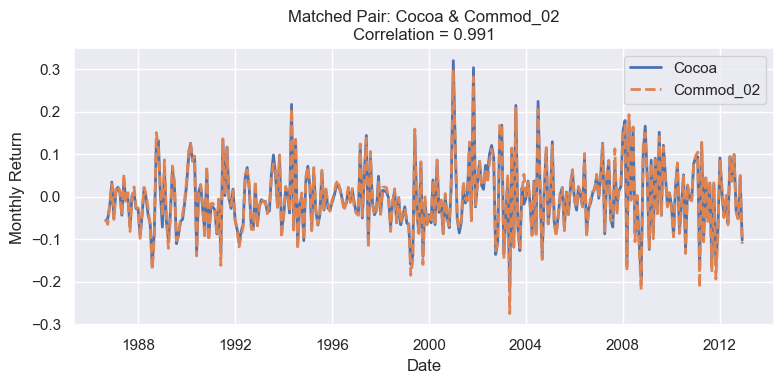

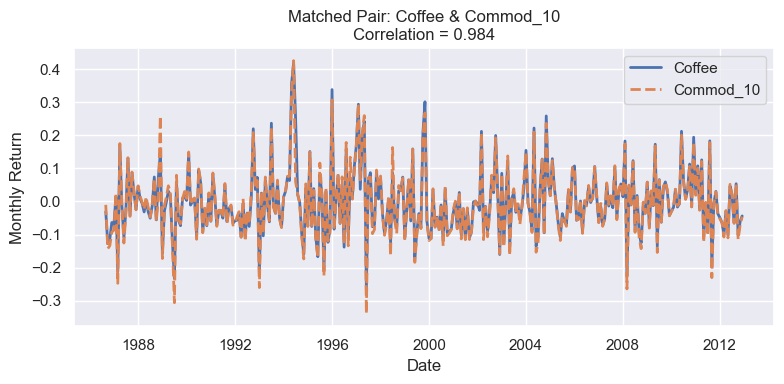

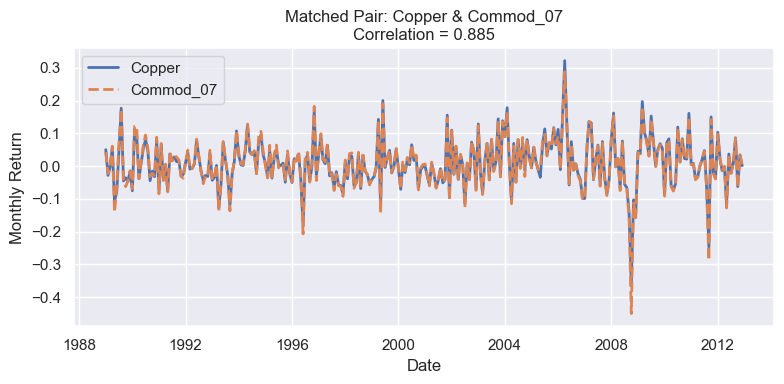

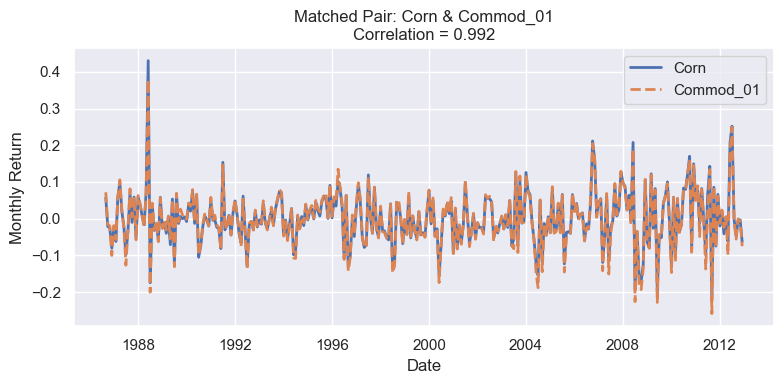

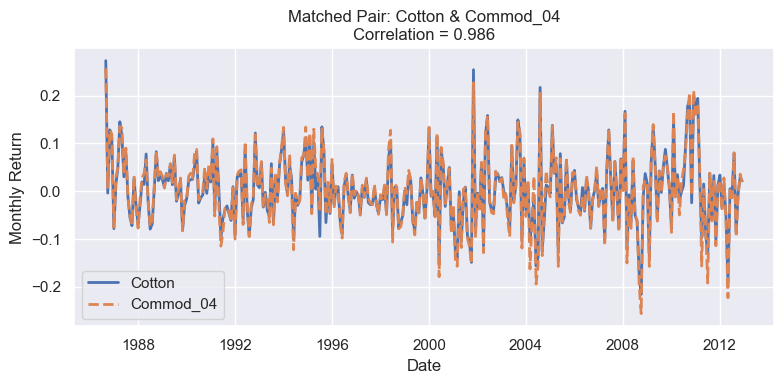

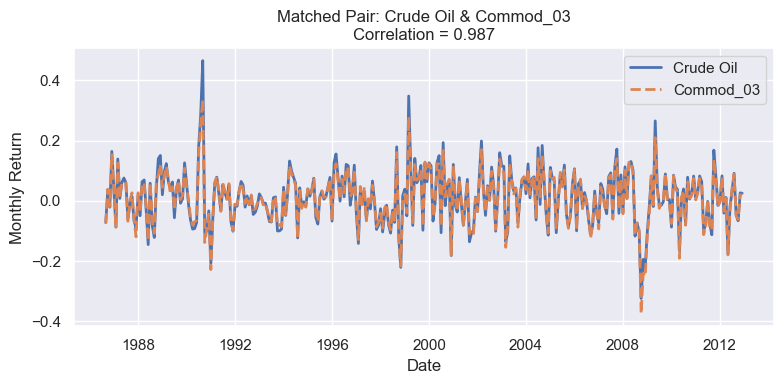

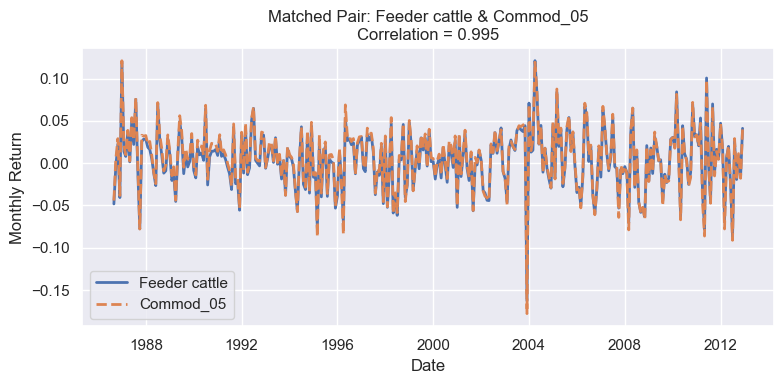

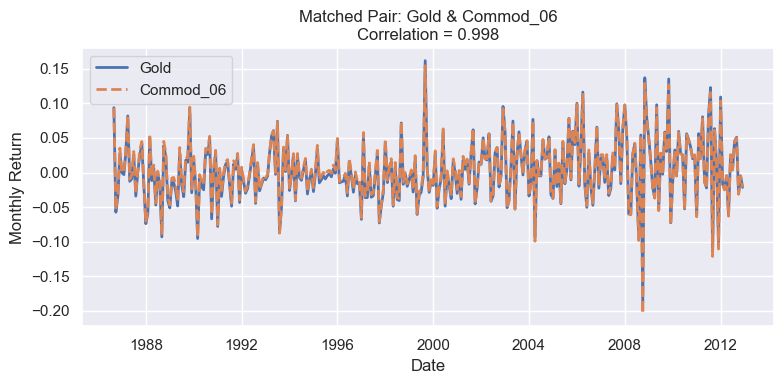

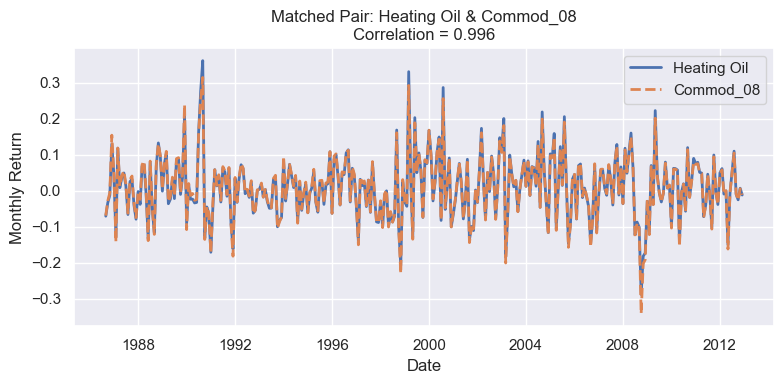

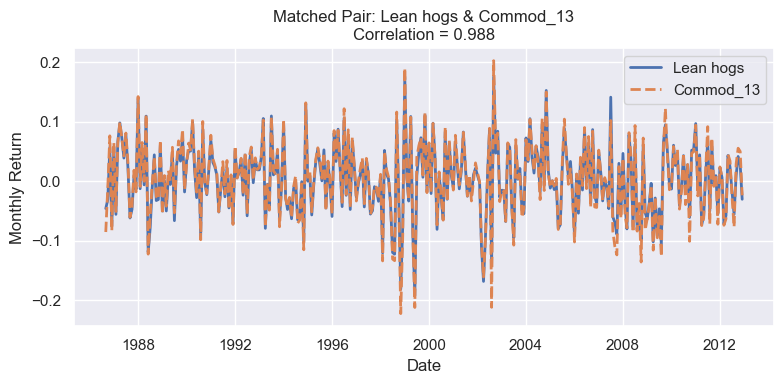

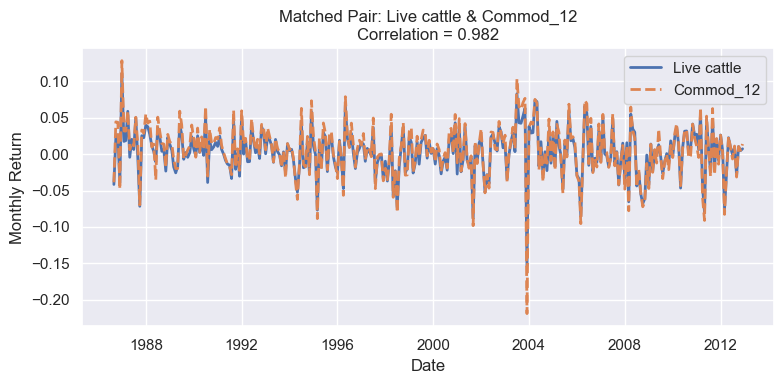

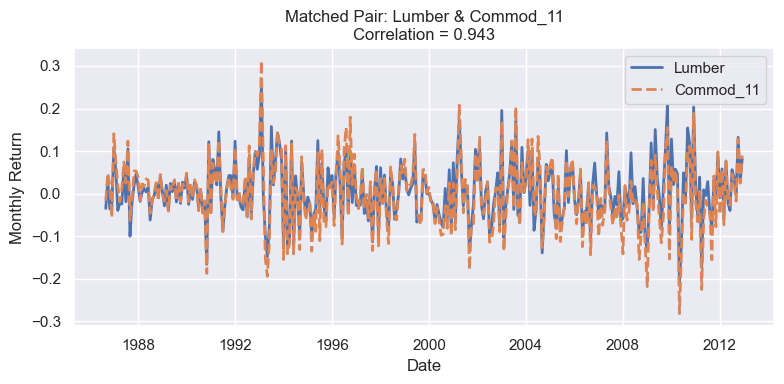

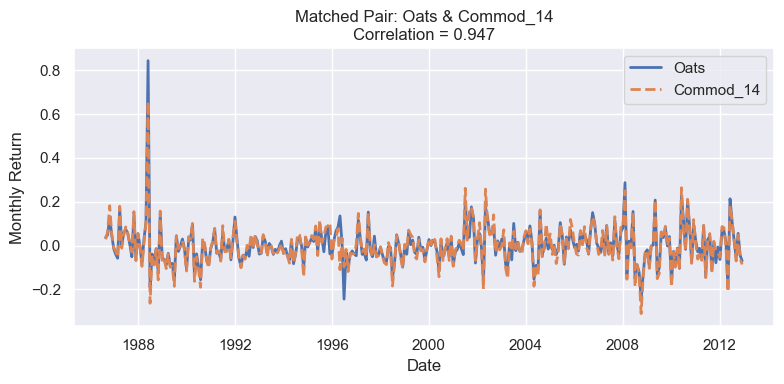

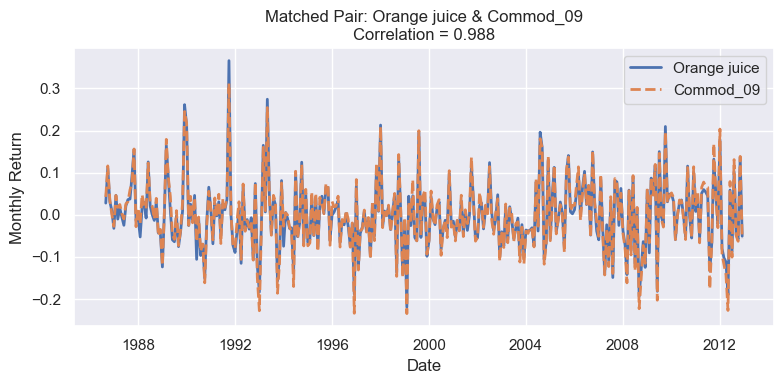

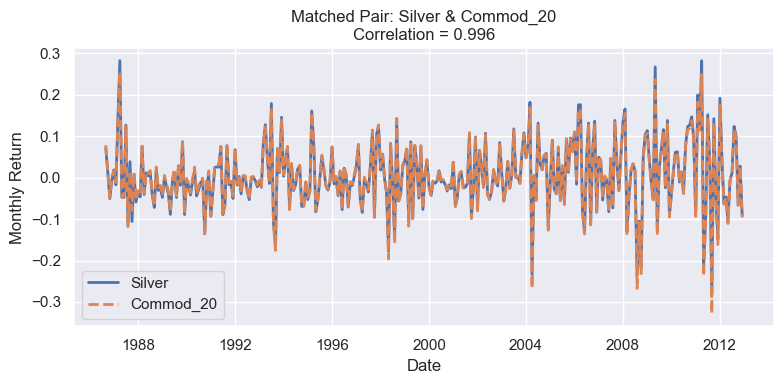

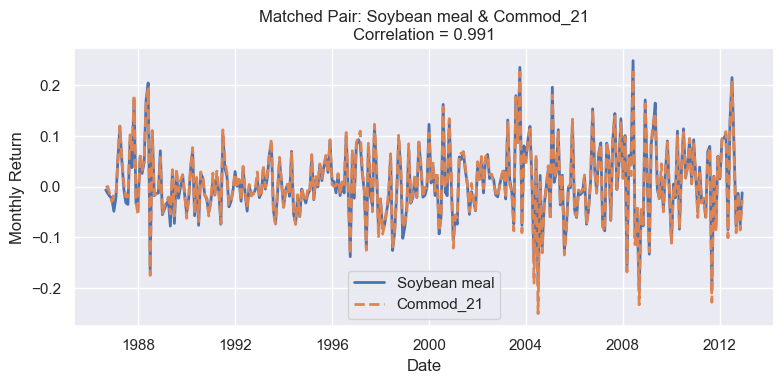

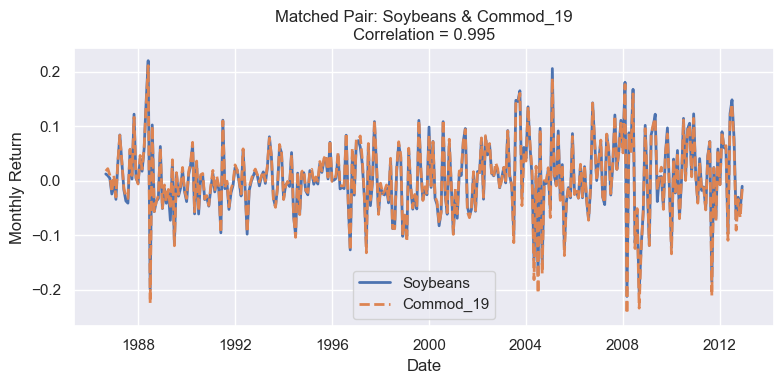

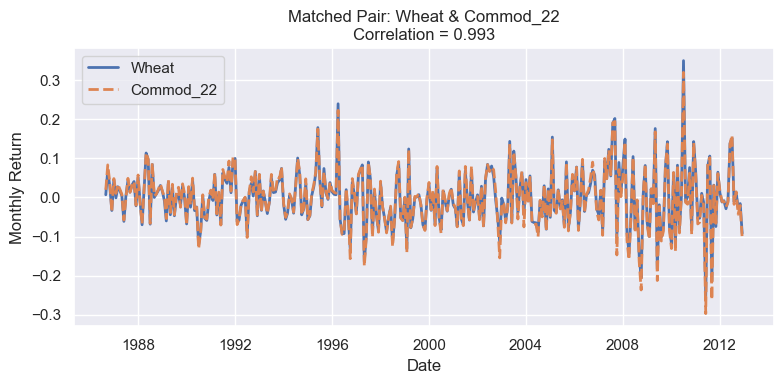

In [ ]:
df1 = monthly_return.copy()
df2 = hkm_df.copy()

for r, c in zip(row_ind, col_ind):
    corr_value = corr_matrix3.iloc[r, c]
    if corr_value < 0.85:
        continue  # Skip low correlation pairs

    commodity_1 = corr_matrix3.index[r]
    commodity_2 = corr_matrix3.columns[c]

    merged = (
        pd.DataFrame(
            {
                "Date": df1["Month"],
                f"d1_{commodity_1}": df1[commodity_1],
                f"d2_{commodity_2}": df2[commodity_2],
            }
        )
        .dropna()
        .set_index("Date")
    )

    plt.figure(figsize=(8, 4))
    plt.plot(
        merged.index, merged[f"d1_{commodity_1}"], label=f"{commodity_1}", linewidth=2
    )
    plt.plot(
        merged.index,
        merged[f"d2_{commodity_2}"],
        label=f"{commodity_2}",
        linewidth=2,
        linestyle="--",
    )

    plt.title(
        f"Matched Pair: {commodity_1} & {commodity_2}\nCorrelation = {corr_value:.3f}"
    )
    plt.xlabel("Date")
    plt.ylabel("Monthly Return")
    plt.legend()
    plt.grid(True)

    plt.xticks()
    plt.tight_layout()
    plt.show()

In [202]:
optimal_pairs_df2

Commodity_1         Commodity_2  Correlation Commodity_Name
0    Commod_06  GC2 Comdty_PX_LAST     0.996136           Gold
1    Commod_20  SI2 Comdty_PX_LAST     0.990287         Silver
2    Commod_02  CC2 Comdty_PX_LAST     0.983713          Cocoa
3    Commod_19  S 2 Comdty_PX_LAST     0.976728       Soybeans
4    Commod_10  KC2 Comdty_PX_LAST     0.971527         Coffee
5    Commod_03  CL2 Comdty_PX_LAST     0.961483      WTI Crude
6    Commod_08  HO2 Comdty_PX_LAST     0.960983    Heating Oil
7    Commod_01  C 2 Comdty_PX_LAST     0.953613           Corn
8    Commod_07              Copper     0.952118         Copper
9    Commod_22  W 2 Comdty_PX_LAST     0.949708          Wheat
10   Commod_05  FC2 Comdty_PX_LAST     0.930403  Feeder Cattle
11   Commod_04  CT2 Comdty_PX_LAST     0.925083         Cotton
12   Commod_17  CO2 Comdty_PX_LAST     0.854062      Crude Oil
13   Commod_12  LC2 Comdty_PX_LAST     0.825750    Live Cattle
14   Commod_13  LH2 Comdty_PX_LAST     0.703030      Lean Hogs
15   Commod_23  KW2 Comdty_PX_LAST     0.429840   Kansas Wheat
16   Commod_16            Aluminum     0.353190       Aluminum
17   Commod_09  XB2 Comdty_PX_LAST     0.235590  Unl. Gasoline
18   Commod_14  SB2 Comdty_PX_LAST     0.223800          Sugar
19   Commod_15              Nickel     0.192999         Nickel
20   Commod_11                Zinc     0.168622           Zinc
21   Commod_21  QS2 Comdty_PX_LAST     0.145876         Gasoil
22   Commod_18                Lead     0.064478           Lead